In [291]:
import pandas as pd
import numpy as np
import pyarrow.dataset as pads
import pyarrow.csv as pacsv
from SMT_Data_Starter_2025 import readDataSubset
import matplotlib.pyplot as plt
from IPython.display import HTML
import great_tables as gt

In [292]:
# Just get the subsets out of the way
game_info_subset = readDataSubset('game_info')
game_events_subset = readDataSubset('game_events')
player_position_subset = readDataSubset('player_pos')
ball_position_subset = readDataSubset('ball_pos')

## Here's how we're going to go about this
1. Get every throw event
   (Note: This might be wrong because the next event_code might just be ball_bounce or deflection, etc.)

2. Attribute each throw with player_id

3. Estimate velocities across each throw
   (Note: should we adjust for the slow-down?)

4. Estimate max.velocities (i.e. "the" velo) of each throw

5. Make some charts

In [293]:
"""
Get every throw event
"""
every_throw = game_events_subset.to_table(
    # filter = pads.field('event_code') == 3, # We're not filtering here to get the next timestamp (to isolate just the throw)
    columns = ['game_str','play_id','play_per_game','timestamp','player_position','event_code']
).to_pandas()
# Make sure it's sorted
every_throw = every_throw.sort_values(by=["game_str","play_id","timestamp"])

# Get the end_time (this is when the ball is caught)
# We will get this by using the timestamp of the next event_code with the same play_id
# WARNING
# WARNING
# WARNING
# This might be wrong because the next event_code might just be ball_bounce or deflection, etc.
# WARNING
# WARNING
# WARNING
# groupby with game_str and play_id makes sure game_str and play_id are the same for both event_code
every_throw['end_time'] = every_throw.groupby(['game_str','play_id'])['timestamp'].shift(-1).astype('Int64')
every_throw = every_throw[every_throw['event_code'] == 3]

# Rename timetamp to start_time (this is when the ball is thrown)
every_throw = every_throw.rename(columns={"timestamp":"start_time"})

every_throw.head(5).T

,8931,8941,8986,9003,9005
game_str,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA
play_id,2,4,17,21,21
play_per_game,2,4,17,21,21
start_time,31649,88399,444799,562499,563799
player_position,9,7,6,5,4
event_code,3,3,3,3,3
end_time,32799,89699,446349,563149,564699


In [294]:
"""
Attribute each throw with player_id
"""
game_info = game_info_subset.to_table().to_pandas()
every_throw = pd.merge(every_throw, game_info, how="inner", on = ['game_str','play_per_game'])
conditions = [
    every_throw['player_position'] == 1,    every_throw['player_position'] == 2,
    every_throw['player_position'] == 3,    every_throw['player_position'] == 4,
    every_throw['player_position'] == 5,    every_throw['player_position'] == 6,
    every_throw['player_position'] == 7,    every_throw['player_position'] == 8,
    every_throw['player_position'] == 9,    every_throw['player_position'] == 10,
    every_throw['player_position'] == 11,    every_throw['player_position'] == 12,
    every_throw['player_position'] == 13,    every_throw['player_position'] == 14,
    every_throw['player_position'] == 15,    every_throw['player_position'] == 16,
    every_throw['player_position'] == 17,    every_throw['player_position'] == 18,
    every_throw['player_position'] == 19,    every_throw['player_position'] == 255
]
choices = [
    every_throw['pitcher'],    every_throw['catcher'],
    every_throw['first_base'],    every_throw['second_base'],
    every_throw['third_base'],    every_throw['shortstop'],
    every_throw['left_field'],    every_throw['center_field'],
    every_throw['right_field'],    every_throw['batter'],
    every_throw['first_baserunner'],    every_throw['second_baserunner'],
    every_throw['third_baserunner'],    "Umpire",
    "Umpire",    "Umpire",
    "Umpire",    "Coach",
    "Coach",    "Ball-event-with-no-player"
]
# throw_id is player_id of the thrower
every_throw['thrower_id'] = np.select(conditions, choices, default=None)
# Rid unused columns
every_throw = every_throw.drop(columns=['pitcher','catcher','first_base','second_base',
                                        'third_base','shortstop','left_field',
                                        'center_field','right_field','batter',
                                        'first_baserunner','second_baserunner',
                                        'third_baserunner','year','day',
                                        'home_team','away_team','top_bottom_inning','at_bat'])

every_throw.head(5).T

,0,1,2,3,4
game_str,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA
play_id,2,4,17,21,21
play_per_game,2,4,17,21,21
start_time,31649,88399,444799,562499,563799
player_position,9,7,6,5,4
event_code,3,3,3,3,3
end_time,32799,89699,446349,563149,564699
thrower_id,QEA-0252,QEA-0249,QEA-0027,QEA-0180,QEA-0365


In [295]:
"""
Estimate velocities across each throw.
We'll do this by distance ÷ time across 2 timestamps
"""
ball_pos = ball_position_subset.to_table(
    columns = ['game_str','play_id','timestamp','ball_position_x','ball_position_y','ball_position_z']
).to_pandas()
# Make sure it's sorted
ball_pos = ball_pos.sort_values(by=["game_str","play_id","timestamp"])
# print(ball_pos.head(50))
every_throw_tracking = pd.merge(every_throw, ball_pos, how="left", on=["game_str","play_id"])

# Estimate velocity at previous interval
every_throw_tracking['prev_ball_pos_x'] = every_throw_tracking.groupby(
    ["game_str","play_id","event_code"])["ball_position_x"].shift(1)
every_throw_tracking['prev_ball_pos_y'] = every_throw_tracking.groupby(
    ["game_str","play_id","event_code"])["ball_position_y"].shift(1)
every_throw_tracking['prev_ball_pos_z'] = every_throw_tracking.groupby(
    ["game_str","play_id","event_code"])["ball_position_z"].shift(1)

# Get displacements
every_throw_tracking['displacement_x'] = every_throw_tracking['ball_position_x'] - every_throw_tracking['prev_ball_pos_x']
every_throw_tracking['displacement_y'] = every_throw_tracking['ball_position_y'] - every_throw_tracking['prev_ball_pos_y']
every_throw_tracking['displacement_z'] = every_throw_tracking['ball_position_z'] - every_throw_tracking['prev_ball_pos_z']
every_throw_tracking['distance'] = np.sqrt(every_throw_tracking['displacement_x']**2 + 
                                           every_throw_tracking['displacement_y']**2 + 
                                           every_throw_tracking['displacement_z']**2)

# Timestamps go in 50ms intervals
every_throw_tracking['prev_interval_speed'] = every_throw_tracking['distance'] / 0.05  # ft/s

# Drop used columns
every_throw_tracking = every_throw_tracking.drop(
    columns=["prev_ball_pos_x","prev_ball_pos_y","prev_ball_pos_z",
             "displacement_x","displacement_y","displacement_z"])

every_throw_tracking.head(64)

,game_str,play_id,play_per_game,start_time,player_position,event_code,end_time,thrower_id,timestamp,ball_position_x,ball_position_y,ball_position_z,distance,prev_interval_speed
0,y1_d001_CGA_QEA,2,2,31649,9,3,32799,QEA-0252,24149,-1.617639,55.9773,6.013500,NaN,NaN
1,y1_d001_CGA_QEA,2,2,31649,9,3,32799,QEA-0252,24199,-1.386153,49.9104,5.764170,6.076432,121.528642
2,y1_d001_CGA_QEA,2,2,31649,9,3,32799,QEA-0252,24249,-1.168065,43.8849,5.458080,6.037210,120.744199
3,y1_d001_CGA_QEA,2,2,31649,9,3,32799,QEA-0252,24299,-0.963375,37.9008,5.095230,5.998584,119.971682
4,y1_d001_CGA_QEA,2,2,31649,9,3,32799,QEA-0252,24349,-0.772083,31.9581,4.675620,5.960566,119.211322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,y1_d001_CGA_QEA,2,2,31649,9,3,32799,QEA-0252,27099,30.445800,175.1325,-0.144846,2.368923,47.378469
60,y1_d001_CGA_QEA,2,2,31649,9,3,32799,QEA-0252,27149,30.873900,177.4380,-0.143931,2.344910,46.898191
61,y1_d001_CGA_QEA,2,2,31649,9,3,32799,QEA-0252,27199,31.297800,179.7192,-0.143368,2.320251,46.405021
62,y1_d001_CGA_QEA,2,2,31649,9,3,32799,QEA-0252,27249,31.717800,181.9767,-0.143156,2.296237,45.924748


In [296]:
# Cleanup noise
# We're gonna get rid of all rows where its prev_interval_speed value is 
#   more than 2.0 ft/s off compared to the row above & below
# Also, we're going to remove all throws >110mph i.e. 161.3ft
every_throw_tracking_clean = every_throw_tracking
every_throw_tracking_clean['speed_above'] = every_throw_tracking_clean.groupby(
    ["game_str","play_id","event_code"])['prev_interval_speed'].shift(1)
every_throw_tracking_clean['speed_below'] = every_throw_tracking_clean.groupby(
    ["game_str","play_id","event_code"])['prev_interval_speed'].shift(-1)
every_throw_tracking_clean['diff_above'] = abs(every_throw_tracking_clean['speed_above'] - every_throw_tracking_clean['prev_interval_speed'])
every_throw_tracking_clean['diff_below'] = abs(every_throw_tracking_clean['speed_below'] - every_throw_tracking_clean['prev_interval_speed'])
every_throw_tracking_clean['min_diff'] = np.minimum(every_throw_tracking_clean['diff_above'], every_throw_tracking_clean['diff_below'])

# For display
display_df = every_throw_tracking_clean.copy() 
display_df['delete'] = ((display_df['min_diff'] > 2.0) | (display_df['prev_interval_speed'] > 161.3))
deleted_rows = every_throw_tracking_clean[(display_df['min_diff'] > 2.0) | (display_df['prev_interval_speed'] > 161.3)]
# Keep row if min_diff <= 2.0 ft/s and prev_interval_speed <= 110mph
every_throw_tracking_clean = every_throw_tracking_clean[(display_df['min_diff'] <= 2.0) & (display_df['prev_interval_speed'] <= 161.3)]
print(f"Number of deleted rows:  {len(deleted_rows)}")
print(f"Number of remaining rows:  {len(every_throw_tracking_clean)}")

# Drop used columns
every_throw_tracking_clean = every_throw_tracking_clean.drop(
    columns=["speed_above","speed_below","diff_above","diff_below"])
display_df = display_df[["game_str","play_id","player_position","event_code","ball_position_x","ball_position_y","ball_position_z","distance","prev_interval_speed","min_diff","delete"]]

# Display
HTML(display_df.head(200)
        .to_html(max_rows=200)
        .replace('<table', '<div style="height:500px;overflow:auto;"><table')
        .replace('</table>', '</table></div>'))

Number of deleted rows:  71714
Number of remaining rows:  957100


,game_str,play_id,player_position,event_code,ball_position_x,ball_position_y,ball_position_z,distance,prev_interval_speed,min_diff,delete
0,y1_d001_CGA_QEA,2,9,3,-1.617639,55.977300,6.013500,NaN,NaN,NaN,False
1,y1_d001_CGA_QEA,2,9,3,-1.386153,49.910400,5.764170,6.076432,121.528642,NaN,False
2,y1_d001_CGA_QEA,2,9,3,-1.168065,43.884900,5.458080,6.037210,120.744199,0.772517,False
3,y1_d001_CGA_QEA,2,9,3,-0.963375,37.900800,5.095230,5.998584,119.971682,0.760359,False
4,y1_d001_CGA_QEA,2,9,3,-0.772083,31.958100,4.675620,5.960566,119.211322,0.749114,False
5,y1_d001_CGA_QEA,2,9,3,-0.594189,26.056860,4.199220,5.923110,118.462208,0.734190,False
6,y1_d001_CGA_QEA,2,9,3,-0.429690,20.196960,3.666090,5.886401,117.728018,0.721876,False
7,y1_d001_CGA_QEA,2,9,3,-0.278589,14.378430,3.076200,5.850307,117.006142,0.708731,False
8,y1_d001_CGA_QEA,2,9,3,-0.140885,8.601270,2.429532,5.814871,116.297411,0.696515,False
9,y1_d001_CGA_QEA,2,9,3,-0.016580,2.865534,1.726113,5.780045,115.600896,0.696515,False


In [297]:
"""
Estimate max.velocities (i.e. "the" velo) of each throw
"""
every_throw_clean = every_throw_tracking_clean.groupby(["game_str","play_id","event_code","player_position","thrower_id"])["prev_interval_speed"].max().reset_index()
every_throw_clean = every_throw_clean.rename(columns={"prev_interval_speed":"throw_speed"})
print(f"Number of original throws: {len(every_throw)}")
print(f"Number of throws after filtering: {len(every_throw_clean)}")

# Convert the speeds to mph
every_throw_clean['throw_mph'] = every_throw_clean['throw_speed'] * 0.681818

every_throw_clean.head(5)

Number of original throws: 9298
Number of throws after filtering: 9223


,game_str,play_id,event_code,player_position,thrower_id,throw_speed,throw_mph
0,y1_d001_CGA_QEA,2,3,9,QEA-0252,120.744199,82.325568
1,y1_d001_CGA_QEA,4,3,7,QEA-0249,127.886159,87.195085
2,y1_d001_CGA_QEA,17,3,6,QEA-0027,130.484917,88.966965
3,y1_d001_CGA_QEA,21,3,4,QEA-0365,119.117614,81.216533
4,y1_d001_CGA_QEA,21,3,5,QEA-0180,117.972067,80.435479


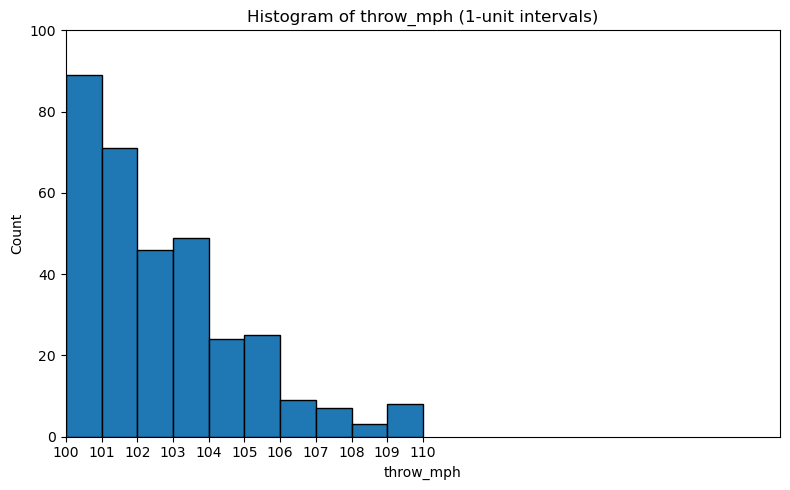

In [298]:
data = every_throw_clean['throw_mph'].dropna()

min_A = np.floor(data.min())
max_A = np.ceil(data.max())
bins = np.arange(min_A, max_A + 1, 1)

plt.figure(figsize=(8, 5))
plt.hist(data, bins=bins, edgecolor='black')
plt.xlabel('throw_mph')
plt.ylabel('Count')
plt.title('Histogram of throw_mph (1-unit intervals)')
plt.xticks(bins)
plt.xlim(100, 120)
plt.ylim(0,100)
plt.tight_layout()
plt.show()

In [299]:
"""
Make some charts
"""
def mode_func(x):
    # Return most common value; if tie, returns the first encountered
    return x.mode().iat[0] if not x.mode().empty else None

charting_df = every_throw_clean.groupby('thrower_id').agg(
    main_pos=('player_position', mode_func),
    max_mph=('throw_mph','max'),
    perc95_mph=('throw_mph', lambda x: x.quantile(0.95)),
    count=('throw_mph', 'size')).reset_index() 

# Rename main position
conditions = [
    charting_df['main_pos'] == 1,    charting_df['main_pos'] == 2,    charting_df['main_pos'] == 3,    charting_df['main_pos'] == 4,
    charting_df['main_pos'] == 5,    charting_df['main_pos'] == 6,    charting_df['main_pos'] == 7,    charting_df['main_pos'] == 8,    charting_df['main_pos'] == 9
]
choices = [
    'pitcher','catcher','first_base','second_base','third_base','shortstop',
    'left_field','center_field','right_field'
]
charting_df['main_pos'] = np.select(conditions, choices, default=None)

# Sort
charting_df = charting_df.sort_values(by='perc95_mph', ascending=False).reset_index(drop=True)
HTML(charting_df.head(100)
        .to_html(max_rows=100)
        .replace('<table', '<div style="height:500px;overflow:auto;"><table')
        .replace('</table>', '</table></div>'))

,thrower_id,main_pos,max_mph,perc95_mph,count
0,YJD-0229,left_field,109.588230,107.444697,7
1,IAK-1196,center_field,106.384288,106.127233,14
2,QZE-2482,pitcher,105.249295,105.249295,1
3,JFU-1658,left_field,107.499461,105.139234,5
4,UPU-1714,center_field,105.079217,105.079217,1
5,ACN-1416,third_base,105.969156,105.026334,3
6,VMN-2242,right_field,106.710570,104.697121,8
7,UWE-1104,shortstop,104.788771,104.545189,9
8,VZE-1946,center_field,104.918901,104.535507,3
9,YJD-0106,center_field,107.239922,104.499975,12


In [300]:
# Visaualize better
(
    # Convert to a great-table
    gt.GT(charting_df.head(20))
    # Title/Subtitle
    .tab_header(title = "Top 20 Arms")
    # Format columns to a certain number of decimal points
    .fmt_number(columns = ["max_mph", "perc95_mph", "count"], decimals = 1)
    .fmt_number(columns = ["count"], decimals=0)
    # Rename columns for the table
    .cols_label(
        thrower_id = "thrower_id",
        max_mph = "Max velo (mph)",
        perc95_mph = "95th percentile",
        count = "Count"
    )
    # Align all columns to center
    .cols_align("center")
    # Color rows with outfielders
    .tab_style(
    # How to style the cells
    style = gt.style.fill(color="#092C5C"),
    # Which cells to style
    locations = gt.loc.body(columns = "main_pos",
                           rows = [0,1,3,4,6,8,9,10,11,13,14,15,16,18,19])
    )
    # Make text color white for outfielders
    .tab_style(
    # How to style the cells
    style = gt.style.text(color="white"),
    # Which cells to style
    locations = gt.loc.body(columns = "main_pos",
                           rows = [0,1,3,4,6,8,9,10,11,13,14,15,16,18,19])
    )
    # Color rows with infielders
    .tab_style(
    style = gt.style.fill(color="#8FBCE6"),
    locations = gt.loc.body(columns = "main_pos",
                           rows = [2])
    )
    # Color Rows with others
    .tab_style(
    style = gt.style.fill(color="#F5D130"),
    locations = gt.loc.body(columns = "main_pos",
                           rows = [5,7,12,17])
    )
    # # To save the table
    # .save("Top-20-Arms.png")
)

GT(_tbl_data=   thrower_id      main_pos     max_mph  perc95_mph  count
0    YJD-0229    left_field  109.588230  107.444697      7
1    IAK-1196  center_field  106.384288  106.127233     14
2    QZE-2482       pitcher  105.249295  105.249295      1
3    JFU-1658    left_field  107.499461  105.139234      5
4    UPU-1714  center_field  105.079217  105.079217      1
5    ACN-1416    third_base  105.969156  105.026334      3
6    VMN-2242   right_field  106.710570  104.697121      8
7    UWE-1104     shortstop  104.788771  104.545189      9
8    VZE-1946  center_field  104.918901  104.535507      3
9    YJD-0106  center_field  107.239922  104.499975     12
10   KJH-1782  center_field  106.736452  104.499909      5
11   IXC-1068  center_field  104.586748  104.112812     14
12   BEJ-1287   second_base  105.028071  104.080689      3
13   HKR-1786  center_field  106.350543  103.972462     15
14   RZQ-0143  center_field  105.612066  103.818308     39
15   YJD-0338  center_field  104.591685  103.744622     53
16   VHS-1062   right_field  105.045655  103.625519      3
17   APZ-1755   second_base  107.266565  103.460480      7
18   HCI-1255  center_field  105.257251  103.441794     10
19   GIS-1420  center_field  103.842966  103.294758     13, _body=<great_tables._gt_data.Body object at 0x000002407B378E60>, _boxhead=Boxhead([ColInfo(var='thrower_id', type=<ColInfoTypeEnum.default: 1>, column_label='thrower_id', column_align='center', column_width=None), ColInfo(var='main_pos', type=<ColInfoTypeEnum.default: 1>, column_label='main_pos', column_align='center', column_width=None), ColInfo(var='max_mph', type=<ColInfoTypeEnum.default: 1>, column_label='Max velo (mph)', column_align='center', column_width=None), ColInfo(var='perc95_mph', type=<ColInfoTypeEnum.default: 1>, column_label='95th percentile', column_align='center', column_width=None), ColInfo(var='count', type=<ColInfoTypeEnum.default: 1>, column_label='Count', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000024035A33710>, _spanners=Spanners([]), _heading=Heading(title='Top 20 Arms', subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='main_pos', rows=[0, 1, 3, 4, 6, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19], mask=None), grpname=None, colname='main_pos', rownum=0, colnum=None, styles=[CellStyleFill(color='#092C5C')]), StyleInfo(locname=LocBody(columns='main_pos', rows=[0, 1, 3, 4, 6, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19], mask=None), grpname=None, colname='main_pos', rownum=1, colnum=None, styles=[CellStyleFill(color='#092C5C')]), StyleInfo(locname=LocBody(columns='main_pos', rows=[0, 1, 3, 4, 6, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19], mask=None), grpname=None, colname='main_pos', rownum=3, colnum=None, styles=[CellStyleFill(color='#092C5C')]), StyleInfo(locname=LocBody(columns='main_pos', rows=[0, 1, 3, 4, 6, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19], mask=None), grpname=None, colname='main_pos', rownum=4, colnum=None, styles=[CellStyleFill(color='#092C5C')]), StyleInfo(locname=LocBody(columns='main_pos', rows=[0, 1, 3, 4, 6, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19], mask=None), grpname=None, colname='main_pos', rownum=6, colnum=None, styles=[CellStyleFill(color='#092C5C')]), StyleInfo(locname=LocBody(columns='main_pos', rows=[0, 1, 3, 4, 6, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19], mask=None), grpname=None, colname='main_pos', rownum=8, colnum=None, styles=[CellStyleFill(color='#092C5C')]), StyleInfo(locname=LocBody(columns='main_pos', rows=[0, 1, 3, 4, 6, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19], mask=None), grpname=None, colname='main_pos', rownum=9, colnum=None, styles=[CellStyleFill(color='#092C5C')]), StyleInfo(locname=LocBody(columns='main_pos', rows=[0, 1, 3, 4, 6, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19], mask=None), grpname=None, colname='main_pos', rownum=10, colnum=None, styles=[CellStyleFill(color='#092C5C')]), StyleInfo(locname=LocBody(columns='main_pos', rows=[0, 1, 3, 